In [1]:
!pip3 install dask
!pip install graphviz
!pip install folium
!pip install gpxpy
!pip install sklearn

    100% |████████████████████████████████| 112kB 4.7MB/s 
  Running setup.py bdist_wheel for gpxpy ... - done
  Stored in directory: /root/.cache/pip/wheels/7c/81/7f/effefbec600ee0ba7f29a29e38754a6e4e1e956538929fdbfd
Successfully built gpxpy


In [2]:
!pip install dask[complete]

  Running setup.py bdist_wheel for locket ... - done
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [0]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
con = sqlite3.connect(r'/content/drive/My Drive/database.sqlite') 

In [12]:
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']

def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)


filteredData['Score']=dfPositiveNegative
print(filteredData.head(5))

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [0]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [15]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [0]:
final['CleanedText']=final_string

In [0]:
final.head(3) #below the processed review can be seen in the CleanedText Column 
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
final=final.sort_values(by='Time')

In [0]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

In [0]:
final=final.sort_values(by='Time')

In [0]:
X_train=final.iloc[0:40000]
Y_train=final['Score_num'].iloc[0:40000]

In [0]:
X_cv=final.iloc[40001:50000]
Y_cv=final['Score_num'].iloc[40001:50000]


In [0]:
X_test=final.iloc[50001:60000]
Y_test=final['Score_num'].iloc[50001:60000]

# tfidf

In [0]:
count_vect = TfidfVectorizer() #in scikit-learn
X_train_vect = count_vect.fit_transform(X_train['CleanedText'].values)
X_cv_vect=count_vect.transform(X_cv['CleanedText'].values)
X_test_vect=count_vect.transform(X_test['CleanedText'].values)

In [0]:
    from sklearn.preprocessing import Normalizer

In [0]:
#column normalization
transformer_tfidf = Normalizer().fit(X_train_vect)
X_train_vect_norm_tfidf=transformer_tfidf.transform(X_train_vect)
X_cv_vect_norm_tfidf=transformer_tfidf.transform(X_cv_vect)
X_test_vect_norm_tfidf=transformer_tfidf.transform(X_test_vect)

In [29]:
print(X_test_vect_norm_tfidf.shape)
print(X_cv_vect_norm_tfidf.shape)
print(X_train_vect_norm_tfidf.shape)

(9999, 24421)
(9999, 24421)
(40000, 24421)


In [0]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score


In [41]:
for i in range(1,16,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(X_train_vect_norm_tfidf, Y_train)
    pred = []
    for j in range(X_cv_vect_norm_tfidf.shape[0]):
        pred.append(knn.predict(X_cv_vect_norm_tfidf[j]))

    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))
    
    



CV accuracy for k = 1 is 85%

 AUC  for k = 1 is 0.590919

CV accuracy for k = 3 is 88%

 AUC  for k = 3 is 0.571843

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.560477

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.554587

CV accuracy for k = 9 is 88%

 AUC  for k = 9 is 0.549675

CV accuracy for k = 11 is 88%

 AUC  for k = 11 is 0.541766

CV accuracy for k = 13 is 88%

 AUC  for k = 13 is 0.542506

CV accuracy for k = 15 is 88%

 AUC  for k = 15 is 0.539509


In [40]:
print(metrics.auc(fpr, tpr))

0.5395087102753964


In [0]:
knn = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
knn.fit(X_train_vect_norm_tfidf,Y_train)
pred_y = []
for j in range(X_test_vect_norm_tfidf.shape[0]):
        pred_y.append(knn.predict(X_test_vect_norm_tfidf[j]))
acc_y = accuracy_score(Y_test, pred_y, normalize=True) * float(100)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred_y)

In [44]:
metrics.auc(fpr, tpr)

0.5658048037282668

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


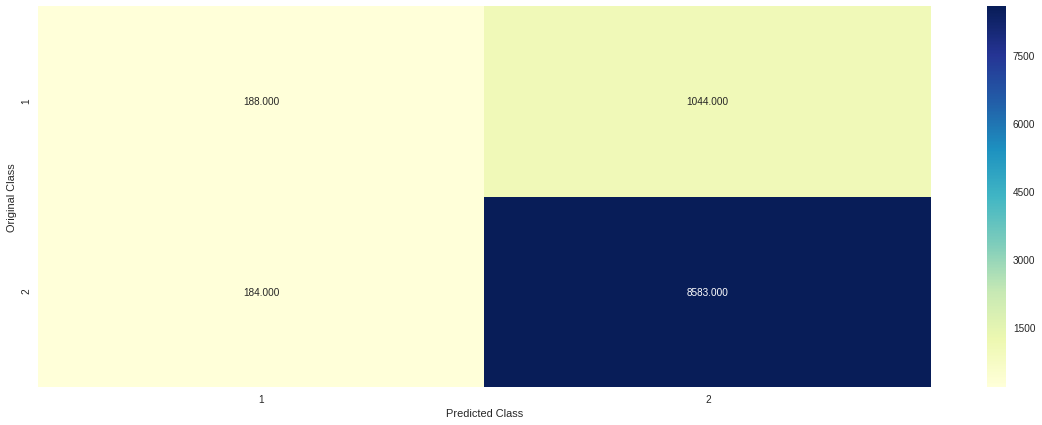

-------------------- Precision matrix (Columm Sum=1) --------------------


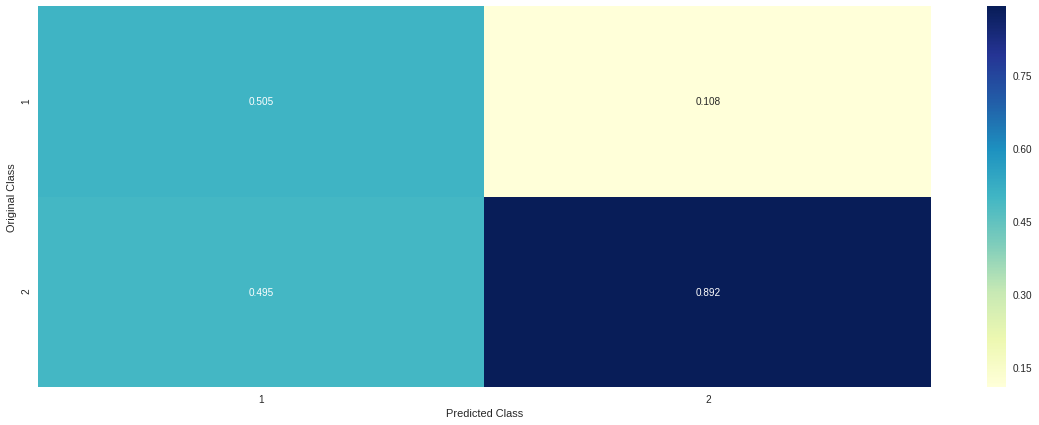

-------------------- Recall matrix (Row sum=1) --------------------


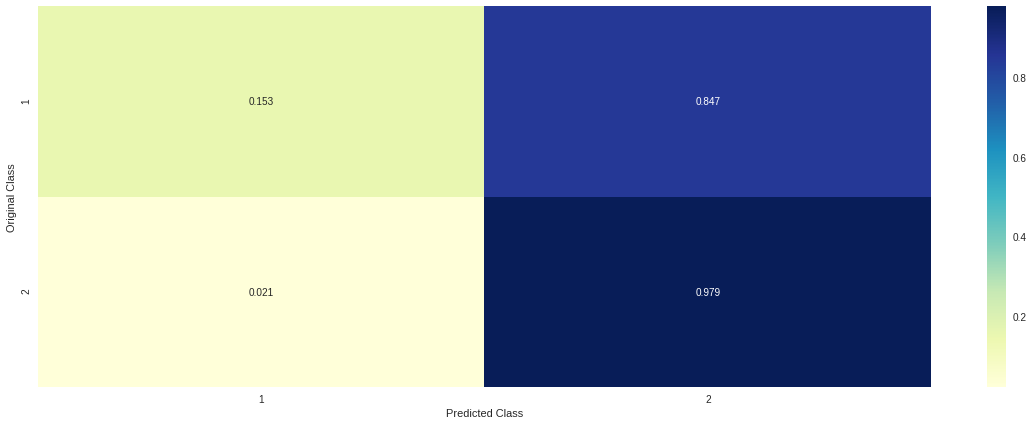

In [46]:
plot_confusion_matrix(Y_test,pred_y)

# TFIDF Knn using Kd tree

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vect_svd =svd.fit_transform(X_train_vect_norm_tfidf)
X_cv_vect_svd =svd.transform(X_cv_vect_norm_tfidf)
X_test_vect_svd =svd.transform(X_test_vect_norm_tfidf)

In [49]:
from sklearn import metrics
for i in range(1,15,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(X_train_vect_svd, Y_train)
    pred = []
    for j in range(X_cv_vect_svd.shape[0]):
        pred.append(knn.predict([X_cv_vect_svd[j]]))

    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    #fpr, tpr, thresholds = metrics.roc_curve(Y_cv, pred, pos_label=2)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))
    #print('\nCV AUC for k = %d is %d%%' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 79%

 AUC  for k = 1 is 0.585751

CV accuracy for k = 3 is 84%

 AUC  for k = 3 is 0.589352

CV accuracy for k = 5 is 86%

 AUC  for k = 5 is 0.585225

CV accuracy for k = 7 is 86%

 AUC  for k = 7 is 0.576217

CV accuracy for k = 9 is 87%

 AUC  for k = 9 is 0.575487

CV accuracy for k = 11 is 87%

 AUC  for k = 11 is 0.565819

CV accuracy for k = 13 is 87%

 AUC  for k = 13 is 0.562712


In [0]:
knn = KNeighborsClassifier(5,algorithm='kd_tree')
knn.fit(X_train_vect_svd,Y_train)
pred = knn.predict(X_test_vect_svd)
acc = accuracy_score(Y_test, pred, normalize=True) * float(100)

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred)

In [52]:
metrics.auc(fpr, tpr)

0.5807675699457381

-------------------- Confusion matrix --------------------


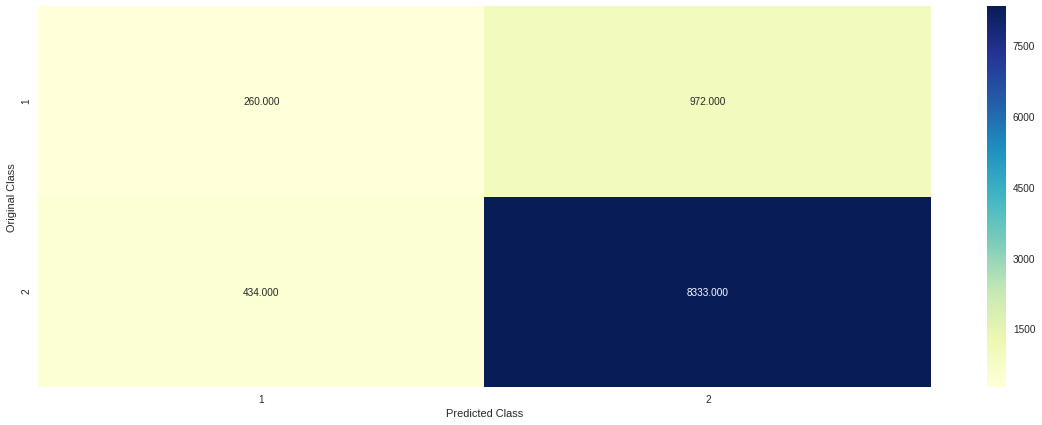

-------------------- Precision matrix (Columm Sum=1) --------------------


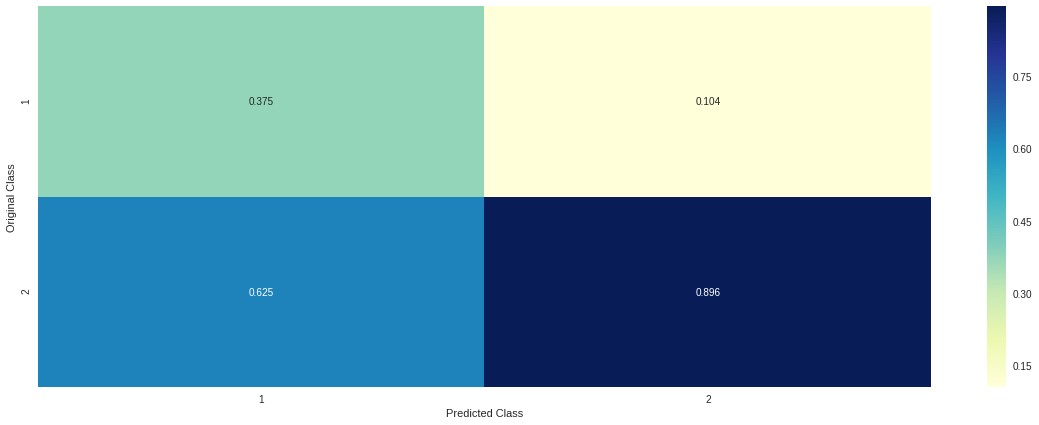

-------------------- Recall matrix (Row sum=1) --------------------


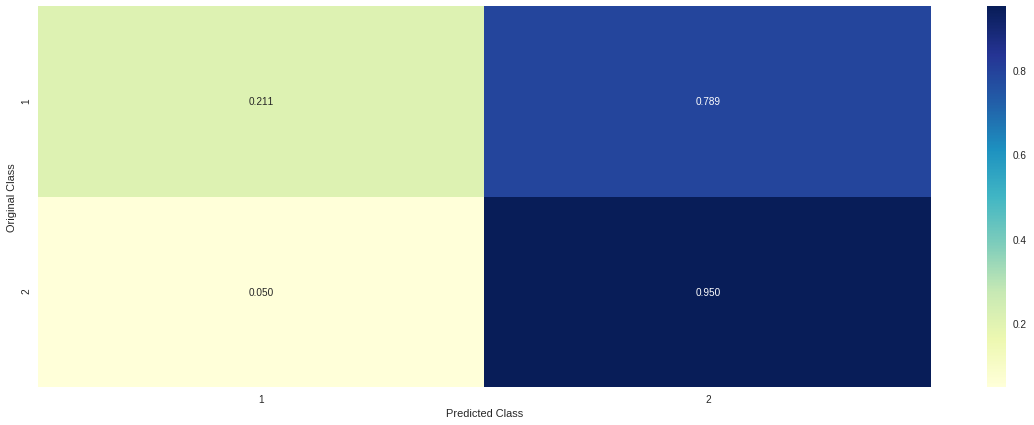

In [53]:
plot_confusion_matrix(Y_test,pred)

# BOW

In [0]:
count_vect_bow=CountVectorizer() #in scikit-learn
X_train_vect_bow = count_vect_bow.fit_transform(X_train['CleanedText'].values)
X_cv_vect_bow = count_vect_bow.transform(X_cv['CleanedText'].values)


In [0]:
X_test_vect_bow=count_vect_bow.transform(X_test['CleanedText'].values)

In [56]:
from sklearn.preprocessing import Normalizer
transformer_bow = Normalizer().fit(X_train_vect_bow)
print(transformer_bow)
X_train_vect_norm_bow=transformer_bow.transform(X_train_vect_bow)
X_cv_vect_norm_bow=transformer_bow.transform(X_cv_vect_bow)

Normalizer(copy=True, norm='l2')


In [0]:
X_test_vect_norm_bow=transformer_bow.transform(X_test_vect_bow)

In [58]:
print(X_train_vect_norm_bow.shape)
print(X_test_vect_norm_bow.shape)
print(X_cv_vect_norm_bow.shape)

(40000, 24421)
(9999, 24421)
(9999, 24421)


In [59]:
for i in range(1,16,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(X_train_vect_norm_bow, Y_train)
    pred = []
    for j in range(X_cv_vect_norm_bow.shape[0]):
        pred.append(knn.predict(X_cv_vect_norm_bow[j]))

    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))
    
    



CV accuracy for k = 1 is 85%

 AUC  for k = 1 is 0.589546

CV accuracy for k = 3 is 87%

 AUC  for k = 3 is 0.564741

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.556500

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.545014

CV accuracy for k = 9 is 88%

 AUC  for k = 9 is 0.539435

CV accuracy for k = 11 is 88%

 AUC  for k = 11 is 0.536113

CV accuracy for k = 13 is 88%

 AUC  for k = 13 is 0.531697

CV accuracy for k = 15 is 88%

 AUC  for k = 15 is 0.528034


In [0]:
knn_optimal = KNeighborsClassifier(n_neighbors=5,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_vect_norm_bow, Y_train)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)
pred = []
for j in range(X_test_vect_norm_bow.shape[0]):
        pred.append(knn_optimal.predict(X_test_vect_norm_bow[j]))

# evaluate accuracy
#acc = accuracy_score(Y_test, pred) * 100
#print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))

In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred)

In [62]:
metrics.auc(fpr, tpr)

0.5548948777069855

# BOW Knn using Kd tree

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)

X_train_vect_svd_bow =svd.fit_transform(X_train_vect_norm_bow)
X_cv_vect_svd_bow =svd.transform(X_cv_vect_norm_bow)
X_test_vect_svd_bow =svd.transform(X_test_vect_norm_bow)

In [64]:
from sklearn import metrics
for i in range(1,15,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(X_train_vect_svd_bow, Y_train)
    pred = []
    for j in range(X_cv_vect_svd_bow.shape[0]):
        pred.append(knn.predict([X_cv_vect_svd_bow[j]]))

    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    #fpr, tpr, thresholds = metrics.roc_curve(Y_cv, pred, pos_label=2)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))
    #print('\nCV AUC for k = %d is %d%%' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 78%

 AUC  for k = 1 is 0.580458

CV accuracy for k = 3 is 83%

 AUC  for k = 3 is 0.577078

CV accuracy for k = 5 is 85%

 AUC  for k = 5 is 0.579564

CV accuracy for k = 7 is 86%

 AUC  for k = 7 is 0.572133

CV accuracy for k = 9 is 86%

 AUC  for k = 9 is 0.572269

CV accuracy for k = 11 is 87%

 AUC  for k = 11 is 0.566493

CV accuracy for k = 13 is 87%

 AUC  for k = 13 is 0.569255


In [65]:
knn_optimal = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_vect_svd_bow, Y_train)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)
pred = []
for j in range(X_test_vect_svd_bow.shape[0]):
        pred.append(knn_optimal.predict([X_test_vect_svd_bow[j]]))

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (11, acc))


The accuracy of the knn classifier for k = 11 is 86.668667%


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred)

In [67]:
metrics.auc(fpr, tpr)

0.5608628745783701

-------------------- Confusion matrix --------------------


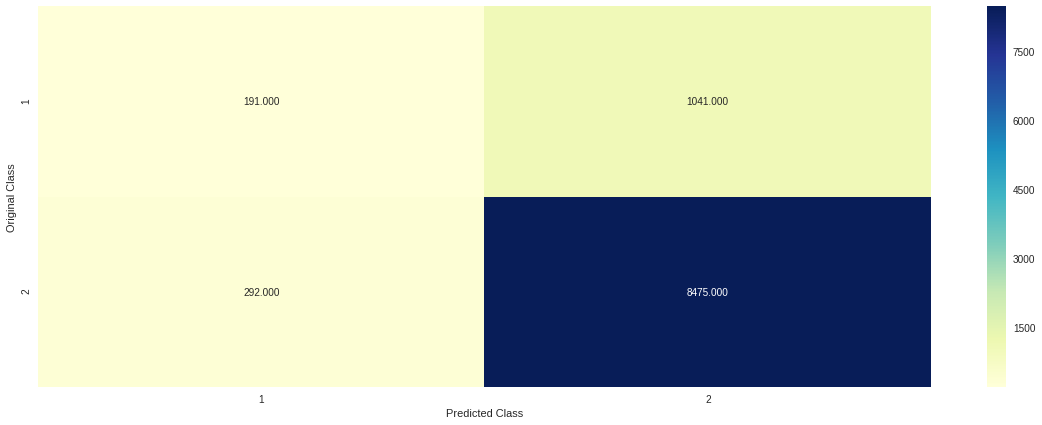

-------------------- Precision matrix (Columm Sum=1) --------------------


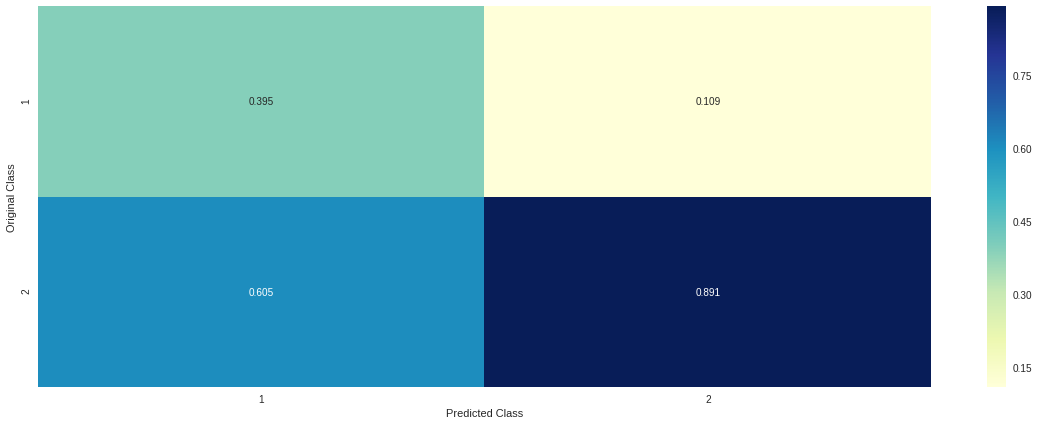

-------------------- Recall matrix (Row sum=1) --------------------


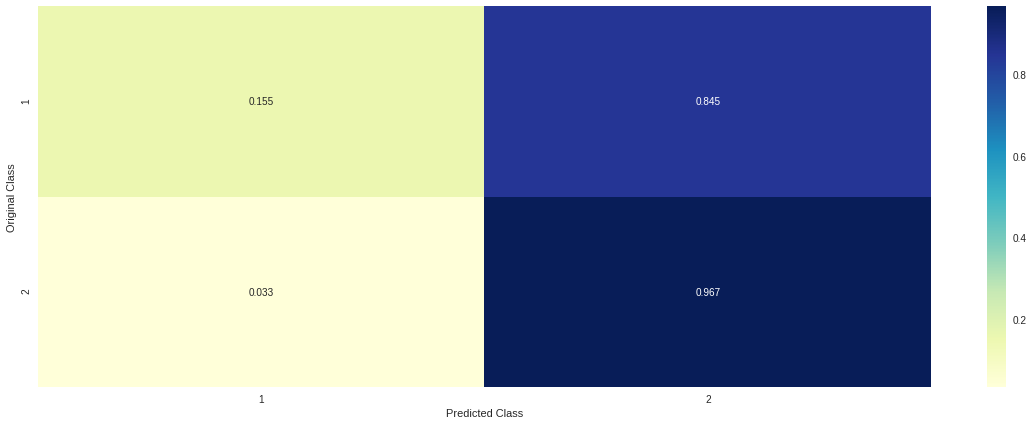

In [68]:
plot_confusion_matrix(Y_test,pred)

# Avg WORD2VEC

In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
X_train_word2vec=final.iloc[0:40000]
Y_train_word2vec=final['Score_num'].iloc[0:40000]

X_cv_word2vec=final.iloc[40001:50000]
Y_cv_word2vec=final['Score_num'].iloc[40001:50000]

X_test_word2vec=final.iloc[50001:60000]
Y_test_word2vec=final['Score_num'].iloc[50001:60000]

In [0]:
list_of_sent_X_train_word2vec=[]
list_of_sent_X_cv_word2vec=[]
list_of_sent_X_test_word2vec=[]

for sent in X_train_word2vec['CleanedText'].values:
    list_of_sent_X_train_word2vec.append(sent.split())
    
for sent in X_cv_word2vec['CleanedText'].values:
    list_of_sent_X_cv_word2vec.append(sent.split())

for sent in X_test_word2vec['CleanedText'].values:
    list_of_sent_X_test_word2vec.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent_X_train_word2vec,min_count=5,size=50, workers=4)

In [0]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

In [0]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_cv_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)

In [0]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

In [0]:
from sklearn.preprocessing import Normalizer
transformer_word2vec = Normalizer().fit(sent_vectors_train)
X_train_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_train)
X_cv_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_cv)

In [0]:
X_test_vect_norm_word2vec=transformer_word2vec.transform(sent_vectors_test)

In [79]:
print(X_train_vect_norm_word2vec.shape)
print(X_cv_vect_norm_word2vec.shape)
print(X_test_vect_norm_word2vec.shape)
print(Y_train_word2vec.shape)

(40000, 50)
(9999, 50)
(9999, 50)
(40000,)


In [80]:
for i in range(1,16,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(X_train_vect_norm_word2vec, Y_train_word2vec)
    pred = []
    for j in range(X_cv_vect_norm_word2vec.shape[0]):
        pred.append(knn.predict([X_cv_vect_norm_word2vec[j]]))

    acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 85%

 AUC  for k = 1 is 0.611696

CV accuracy for k = 3 is 88%

 AUC  for k = 3 is 0.607270

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.601470

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.587698

CV accuracy for k = 9 is 89%

 AUC  for k = 9 is 0.588879

CV accuracy for k = 11 is 89%

 AUC  for k = 11 is 0.583569

CV accuracy for k = 13 is 89%

 AUC  for k = 13 is 0.585189

CV accuracy for k = 15 is 89%

 AUC  for k = 15 is 0.581198


In [81]:
knn_optimal = KNeighborsClassifier(n_neighbors=9,algorithm='brute')

# fitting the model
knn_optimal.fit(X_train_vect_norm_word2vec, Y_train_word2vec)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)

pred = []

for j in range(X_test_vect_norm_word2vec.shape[0]):
        pred.append(knn_optimal.predict([X_test_vect_norm_word2vec[j]]))

# evaluate accuracy
acc = accuracy_score(Y_test_word2vec, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (9, acc))


The accuracy of the knn classifier for k = 9 is 88.788879%


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred)

In [83]:
metrics.auc(fpr, tpr)

0.5862085295507503

-------------------- Confusion matrix --------------------


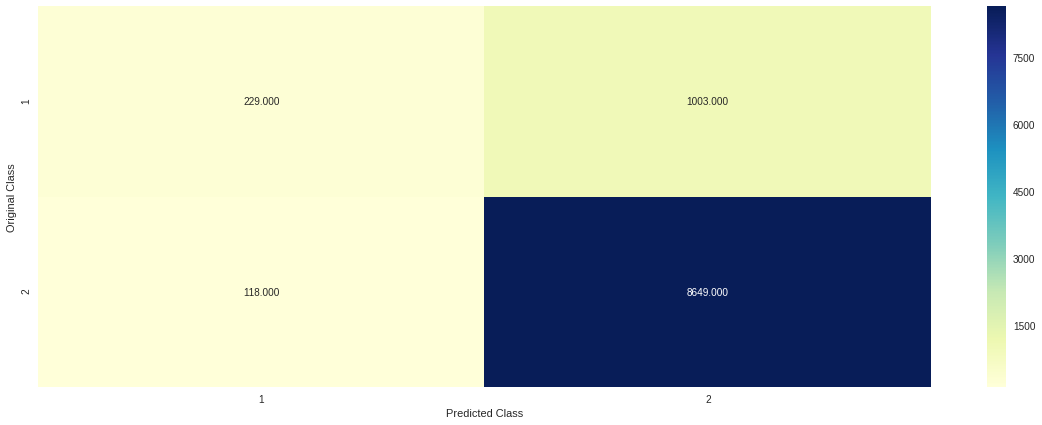

-------------------- Precision matrix (Columm Sum=1) --------------------


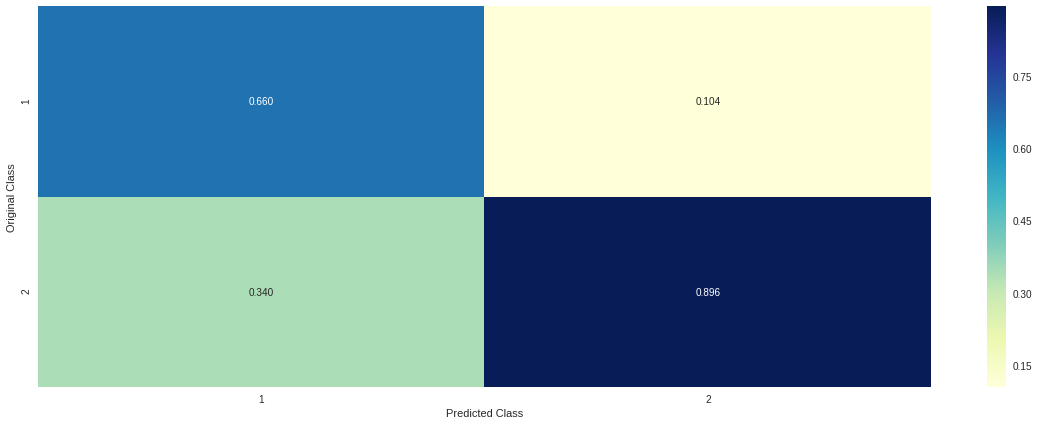

-------------------- Recall matrix (Row sum=1) --------------------


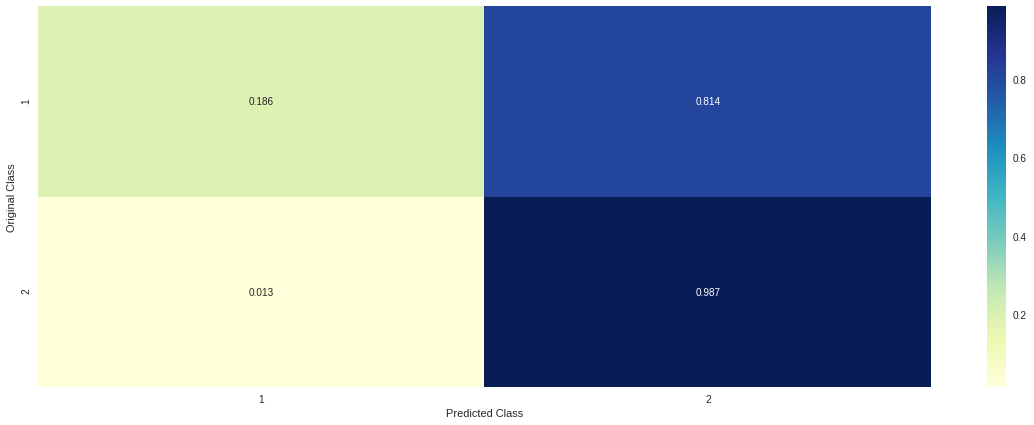

In [84]:
plot_confusion_matrix(Y_test,pred)

# word2vec-KD tree

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=49)
X_train_vect_svd_word2vec =svd.fit_transform(X_train_vect_norm_word2vec)
X_cv_vect_svd_word2vec =svd.transform(X_cv_vect_norm_word2vec)
X_test_vect_svd_word2vec =svd.transform(X_test_vect_norm_word2vec)

In [87]:
from sklearn import metrics
for i in range(1,17,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(X_train_vect_svd_word2vec,Y_train_word2vec)
    pred = []
    for j in range(X_cv_vect_svd_word2vec.shape[0]):
        pred.append(knn.predict([X_cv_vect_svd_word2vec[j]]))

    acc = accuracy_score(Y_cv_word2vec, pred, normalize=True) * float(100)
    #fpr, tpr, thresholds = metrics.roc_curve(Y_cv, pred, pos_label=2)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 85%

 AUC  for k = 1 is 0.613642

CV accuracy for k = 3 is 88%

 AUC  for k = 3 is 0.606504

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.600392

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.589643

CV accuracy for k = 9 is 89%

 AUC  for k = 9 is 0.587885

CV accuracy for k = 11 is 88%

 AUC  for k = 11 is 0.582802

CV accuracy for k = 13 is 89%

 AUC  for k = 13 is 0.584365

CV accuracy for k = 15 is 89%

 AUC  for k = 15 is 0.582547


In [89]:
knn_optimal = KNeighborsClassifier(n_neighbors=13,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train_vect_svd_word2vec,Y_train_word2vec)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)
pred = []
for j in range(X_test_vect_svd_word2vec.shape[0]):
        pred.append(knn_optimal.predict([X_test_vect_svd_word2vec[j]]))

# evaluate accuracy
acc = accuracy_score(Y_test_word2vec, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (13, acc))


The accuracy of the knn classifier for k = 13 is 88.758876%


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_word2vec, pred)

In [91]:
metrics.auc(fpr, tpr)

0.5776659429027685

-------------------- Confusion matrix --------------------


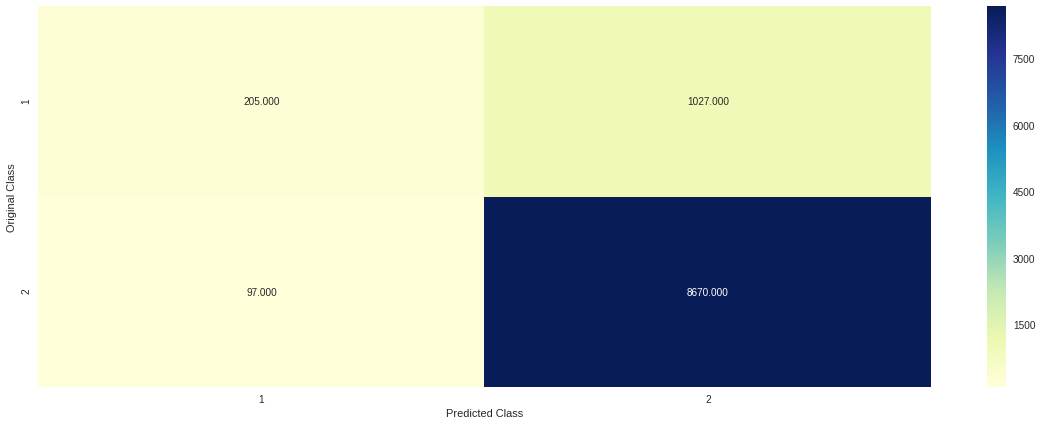

-------------------- Precision matrix (Columm Sum=1) --------------------


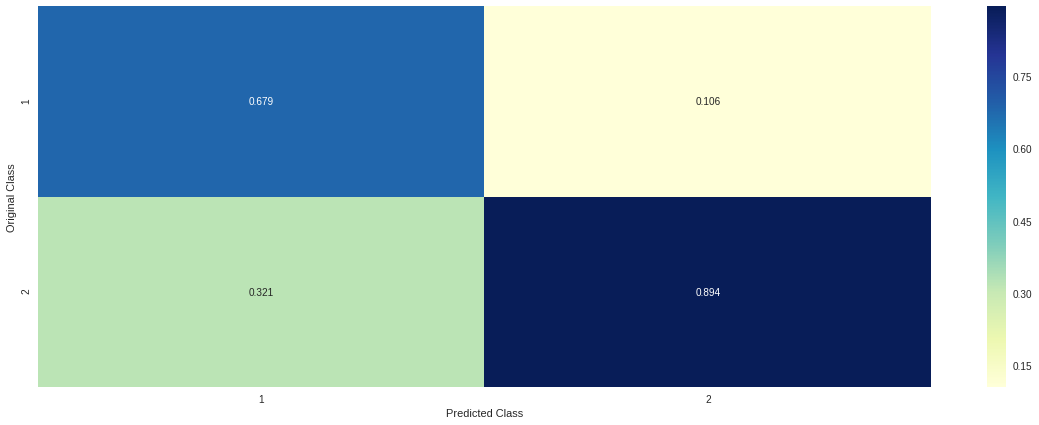

-------------------- Recall matrix (Row sum=1) --------------------


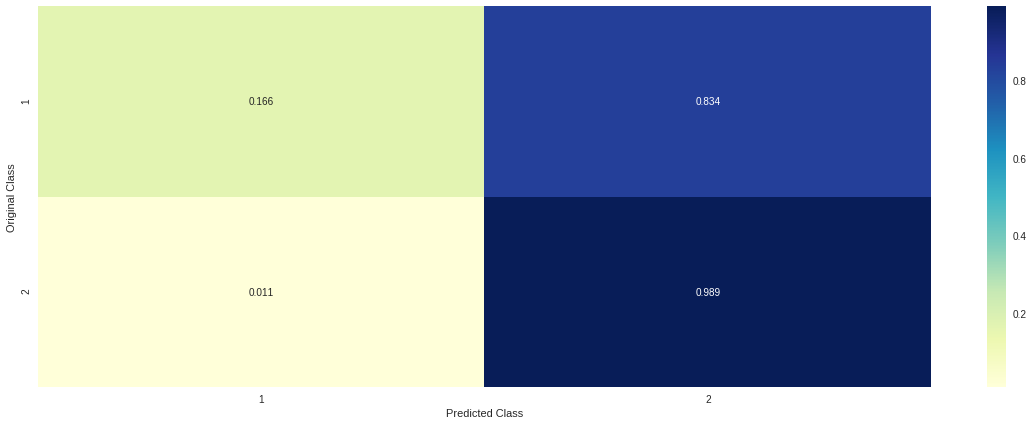

In [92]:
plot_confusion_matrix(Y_test_word2vec,pred)

# tfidf word2vec

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_cv_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_cv_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
            
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
        
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [0]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    try:    
        sent_vec /= weight_sum
    except ZeroDivisionError:
        sent_vec=0
    #print(sent_vec)
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [98]:
from sklearn.preprocessing import Normalizer
transformer_tfidfword2vec = Normalizer().fit(tfidf_sent_vectors_train)
print(transformer_word2vec)
tfidf_sent_vectors_train_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_cv)

Normalizer(copy=True, norm='l2')


In [0]:
tfidf_sent_vectors_test_norm=transformer_tfidfword2vec.transform(tfidf_sent_vectors_test)

In [0]:
from sklearn.model_selection import cross_val_score

In [104]:
from sklearn import metrics
for i in range(1,17,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')

    knn.fit(tfidf_sent_vectors_train_norm,Y_train_word2vec)
    pred = []
    for j in range(tfidf_sent_vectors_cv_norm.shape[0]):
        pred.append(knn.predict([tfidf_sent_vectors_cv_norm[j]]))

    acc = accuracy_score(Y_cv_word2vec, pred, normalize=True) * float(100)
    #fpr, tpr, thresholds = metrics.roc_curve(Y_cv, pred, pos_label=2)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv_word2vec,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 84%

 AUC  for k = 1 is 0.604414

CV accuracy for k = 3 is 87%

 AUC  for k = 3 is 0.589725

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.593487

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.582313

CV accuracy for k = 9 is 88%

 AUC  for k = 9 is 0.573312

CV accuracy for k = 11 is 88%

 AUC  for k = 11 is 0.571524

CV accuracy for k = 13 is 88%

 AUC  for k = 13 is 0.568799

CV accuracy for k = 15 is 88%

 AUC  for k = 15 is 0.568544


In [105]:
knn_optimal = KNeighborsClassifier(n_neighbors=5,algorithm='brute')

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train_norm, Y_train)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)

pred = []

for j in range(tfidf_sent_vectors_test_norm.shape[0]):
        pred.append(knn_optimal.predict([tfidf_sent_vectors_test_norm[j]]))

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (5, acc))


The accuracy of the knn classifier for k = 5 is 88.008801%


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_word2vec, pred)

In [107]:
metrics.auc(fpr, tpr)

0.5838529021167038

-------------------- Confusion matrix --------------------


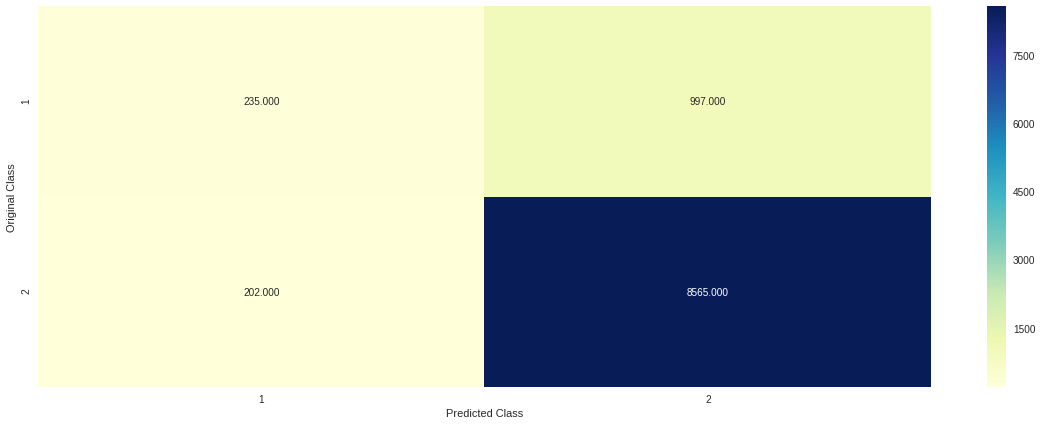

-------------------- Precision matrix (Columm Sum=1) --------------------


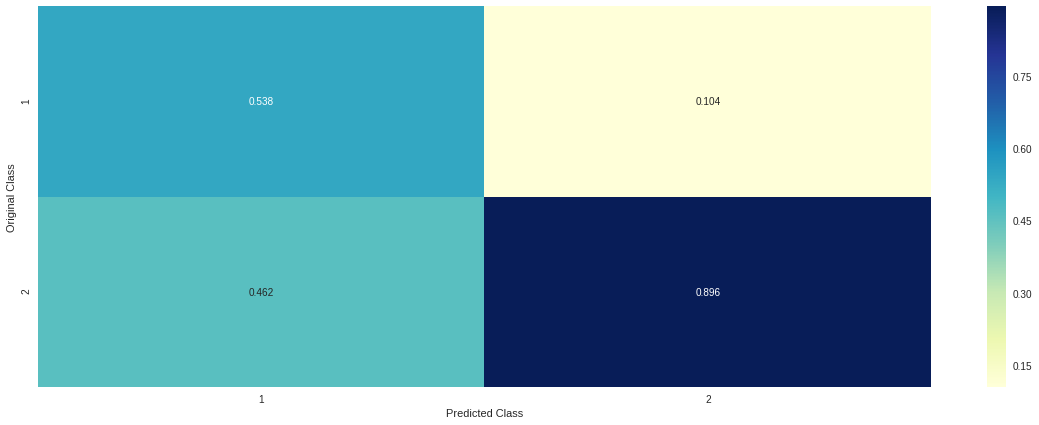

-------------------- Recall matrix (Row sum=1) --------------------


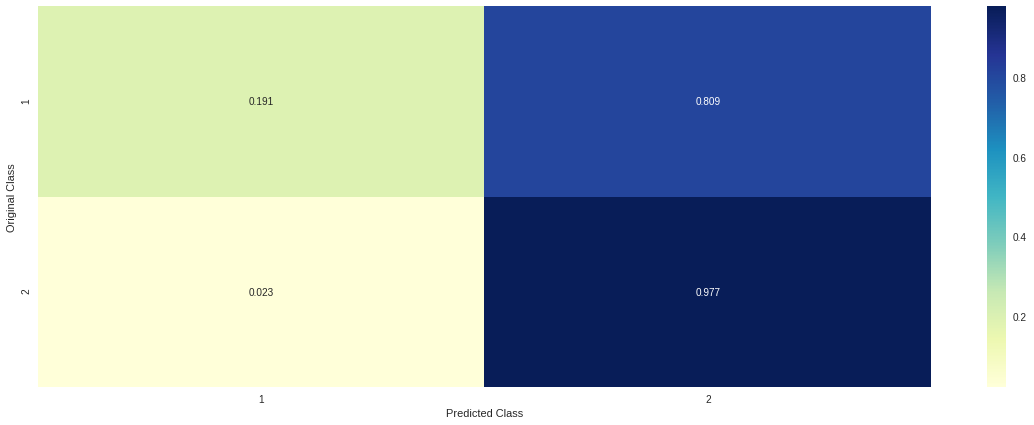

In [108]:
plot_confusion_matrix(Y_test_word2vec,pred)

# tfidf word2vec Knn using Kd tree

In [109]:
from sklearn import metrics
for i in range(1,17,2):
   
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')

    knn.fit(tfidf_sent_vectors_train_norm,Y_train_word2vec)
    pred = []
    for j in range(tfidf_sent_vectors_cv_norm.shape[0]):
        pred.append(knn.predict([tfidf_sent_vectors_cv_norm[j]]))

    acc = accuracy_score(Y_cv_word2vec, pred, normalize=True) * float(100)
    #fpr, tpr, thresholds = metrics.roc_curve(Y_cv, pred, pos_label=2)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc))
    fpr, tpr, thresholds = metrics.roc_curve(Y_cv_word2vec,pred)
    print('\n AUC  for k = %d is %f' % (i, metrics.auc(fpr, tpr)))


CV accuracy for k = 1 is 84%

 AUC  for k = 1 is 0.604414

CV accuracy for k = 3 is 87%

 AUC  for k = 3 is 0.589725

CV accuracy for k = 5 is 88%

 AUC  for k = 5 is 0.593487

CV accuracy for k = 7 is 88%

 AUC  for k = 7 is 0.582313

CV accuracy for k = 9 is 88%

 AUC  for k = 9 is 0.573312

CV accuracy for k = 11 is 88%

 AUC  for k = 11 is 0.571524

CV accuracy for k = 13 is 88%

 AUC  for k = 13 is 0.568799

CV accuracy for k = 15 is 88%

 AUC  for k = 15 is 0.568544


In [114]:
knn_optimal = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree')

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train_norm, Y_train)

# predict the response
#pred = knn_optimal.predict(X_test_vect_norm_tfidf)
pred = []
for j in range(tfidf_sent_vectors_test_norm.shape[0]):
        pred.append(knn_optimal.predict([tfidf_sent_vectors_test_norm[j]]))

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (5, acc))


The accuracy of the knn classifier for k = 5 is 88.008801%


In [0]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test_word2vec, pred)

In [121]:
metrics.auc(fpr, tpr)

0.5838529021167038

-------------------- Confusion matrix --------------------


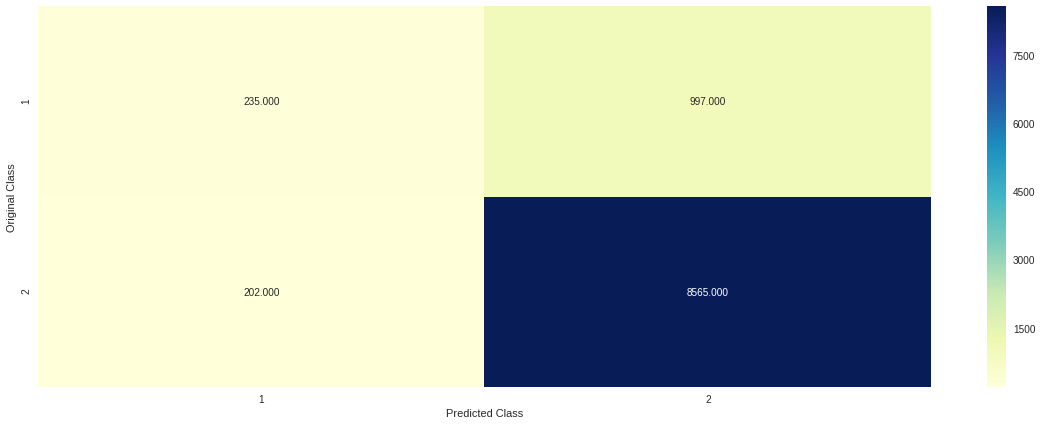

-------------------- Precision matrix (Columm Sum=1) --------------------


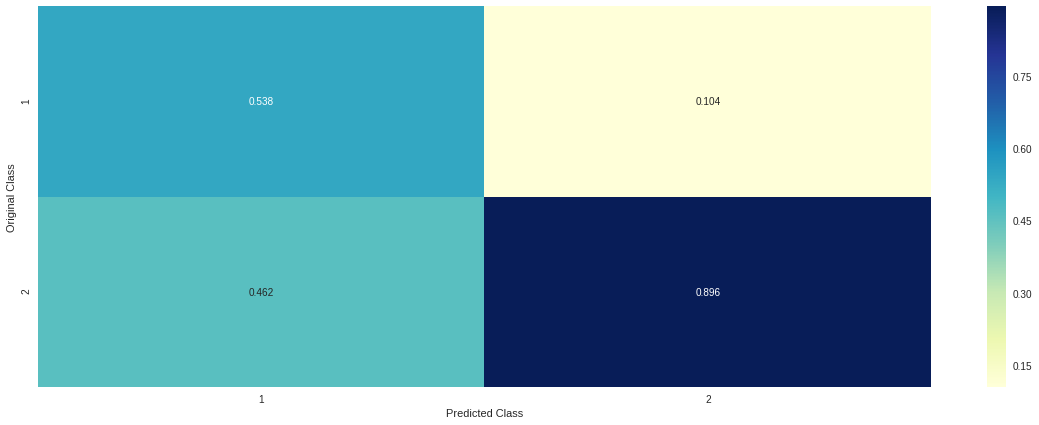

-------------------- Recall matrix (Row sum=1) --------------------


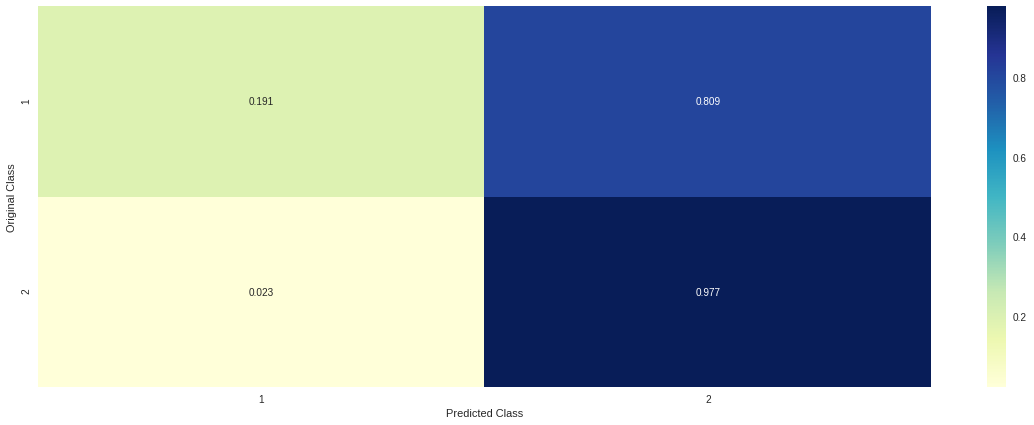

In [117]:
plot_confusion_matrix(Y_test_word2vec,pred)

# Conclusion

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [0]:
x.field_names = ["Type of vectorizer", "Brute force optimized k ", "Kd Tree optimized k"]

In [0]:
x.add_row(["TFIDF","K=11 and acc=0.565","k =5 and 0.58"])
x.add_row(["BOW","k = 5 and 0.554","k = 11 and 0.5608"])
x.add_row(["Avg WORD2VEC","k = 9 and 0.586","k = 13 and 0.577"])
x.add_row(["tfidf word2vec","k = 5 and 0.583","k = 5 and 0.583"])

In [131]:
print(x)

+--------------------+--------------------------+---------------------+
| Type of vectorizer | Brute force optimized k  | Kd Tree optimized k |
+--------------------+--------------------------+---------------------+
|       TFIDF        |    K=11 and acc=0.565    |    k =5 and 0.58    |
|        BOW         |     k = 5 and 0.554      |  k = 11 and 0.5608  |
|    Avg WORD2VEC    |     k = 9 and 0.586      |   k = 13 and 0.577  |
|   tfidf word2vec   |     k = 5 and 0.583      |   k = 5 and 0.583   |
+--------------------+--------------------------+---------------------+
